%HTML
<center>
<div style="font-size: xx-large; margin-bottom: 1ex">Vector Race</div>
<div style="font-size: large">Christian Holm Christensen</div>
</center>


Let us import some packages to start out.

In [1]:
%matplotlib notebook 
import sys
import json
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path
import matplotlib.transforms
import matplotlib.colors
import matplotlib.patches as pc


# The `Car` objects

Let's define a class that represents a car.  Objects of this class corresponds to a single "player".  The class of cars store a colour and a history of position.  We can query the objects for the full trajectory as well as current and previous positions.    

In [2]:
class Car:
    """
    A car in the race track
    
    This keeps track for the trajectory and history of moves.  
    Objects can be quired for position, previous postion, 
    direction, and vectors suitable for MatPlotLib quiver plots. 
    
    """
    def __init__(self,x,y,c='k'):
        """
        Initialize the object. 
        
        Parameters
        ----------
            x : value 
                Initial X-coordinate of the car 
            Y : value 
                Initial Y-coordinate of the car 
            C : color 
                Color and identifier of this car 
        """
        self._c = c # Colour and identifier
        self._t = np.array([x,y],ndmin=2,dtype=np.int)
        self._s = False # Stopped!
        
    def direction(self):
        """
        Get last direction
        
        Returns
        -------
            pair
                (X,Y) vector of the current direction
        
        """
        if self._s or len(self._t) <= 1: 
            return np.zeros(2,dtype=np.int)
        return np.diff(self._t[-2:],axis=0)[0]
    
    def start(self):
        """Get start position"""
        return self._t[0]
    
    def position(self):
        """
        Get last position
        
        Returns
        -------
            pair
                (x,Y) coordinates of the current position of the car
        
        """
        return self._t[-1]
    
    def previous(self):
        """
        Get the previous position
        
        Returns
        -------
            pair
                (X,Y) coordinates of the previous position of the car
        
        """
        if len(self._t) <= 1: return self.position()
        return self._t[-2]
    
    def step(self,t):
        """
        Get step from history
        
        Parameters
        ----------
            t : int 
                Step number in history 
                
        Returns
        -------
            pair 
                (X,Y) move from history or none 
        """
        if t >= len(self._t): return None
        return np.diff(self._t[t-1:t+1],axis=0)[0]
    
    def trajectory(self):
        """
        Get list of X,Y coordinates and U,V directions
        
        These can be used to plot the trajectory of the car using a quiver plot 
        
        Returns
        -------
            x : values
                List of X coordinates up to (but not including) current position
            y : values
                List of Y coordinates up to (but not including) current position
            u : values
                Step sizes in the X direction leading up to current position
            v : values
                Step sizes in the Y direction leading up to current position
               
        """
        x = self._t[:,0]
        y = self._t[:,1]
        d = np.diff(self._t,axis=0)
        u = d[:,0]
        v = d[:,1]
        return x, y, u, v
    
    def push(self,dx,dy):
        """Do another move.  
        
        Note that the arguments specifify the _change_ in velocity
        
        Parameters
        ----------
            dx : value
                Acceleration in X direction
            dy : value
                Acceleration in Y direction
            t : time
                Current time 
        """
        c = self.position()
        d = self.direction()
        a = np.array((dx,dy),dtype=np.int)
        n = c+d+a
        self._t = np.append(self._t, n[np.newaxis], axis=0)
        self._s = False
        
    def pop(self):
        """Pop last move"""
        self._t = self._t[:-1]
        
    def stop(self,x=None,y=None):
        """
        If the player hit a barrier, add a copy of the last point
        
        Parameters:
            x : value, optional 
                If specified, X coordinate of the last position to set 
            y : value, optional 
                If specified, Y coordinate of the last postion to set
        """
        # First, pop the point we recently pushed 
        self.pop()
        if x is None or y is None:
            p = self.position()
        else:
            p = np.array([x,y],dtype=np.int)
        self._t = np.append(self._t, p[np.newaxis], axis=0)
        self._s = True
  
    def stopped(self):
        """Check if car is stopped"""
        return self._s

    def moves(self):
        """Get list of moves
        
        Returns
        ------- 
            moves : array-like 
                The list of moves 
        """
        x,y,u,v = self.trajectory()
        u = np.concatenate(([0],u))
        v = np.concatenate(([0],v))
        du = np.diff(u)
        dv = np.diff(v)
        return np.stack((du,dv),axis=-1)
    
    def size(self):
        """
        Get number of steps
        
        Returns
        -------
            int 
                Number of steps in current trajectory
        """
        return len(self._t)
    
    def color(self):
        return self._c
    
    def __str__(self):
        x,y,u,v = self.trajectory()
        u0 = 0
        v0 = 0
        with io.StringIO() as stream:
            print("Car {}".format(self._c))
            for i,(xi,yi,ui,vi) in enumerate(zip(x,y,u,v)):
                print("  {:2d}: {:3d},{:3d} + {:3d},{:3d} [{:3d},{:3d}]"
                      .format(i,xi,yi,ui,vi,ui-u0,vi-v0),file=stream)
                u0, v0 = ui, vi
            print("  {:2d}: {:3d},{:3d}"
                  .format(len(x)-1,x[-1],y[-1]),file=stream)
            
            return stream.getvalue()

## Test of the `Car` class

Let's make a small test to see that we can make a trajectory

In [3]:
def testCar():
    plt.figure(1)
    car = Car(0,0,1)
    for i in range(10):
        dx = np.random.randint(-1,1)
        dy = np.random.randint(-1,1)
        car.push(dx,dy)
    x,y,u,v = car.trajectory()
    plt.quiver(x[:-1],y[:-1],u,v,angles='xy',scale_units='xy',scale=1)
    plt.plot(x,y,"o",color="red")
    plt.show()
    print(car)
# testCar()

# The `TrackCreator` factory

Next, we define a class to make tracks.  We use the class `matlibplot.path.Path` to encode the outer and inner path that makes up a track.  This class can do many different kinds of paths, but here we will use mainly polygon paths. 

In [4]:
class TrackCreator:
    """
    A class to make trakcs 
    """
    def __init__(self):
        pass
    
    def regularPolygon(self,n,r,x=0,y=0,phi=0):
        """
        Create a regular polygon path. 
        
        Parameters
        ----------
            n : int
                Number of sides
            r : float
                The radius of circumscribed circle
            x : float, optional
                X-coordinate of center 
            y : float, optional 
                Y-coordinate of center
            phi : float, optional
                Rotation angle (in radians) around center point
            
        Returns
        --------
            path :
                A regular polygon path
        """
        # Make our transform 
        t = matplotlib.transforms.Affine2D().scale(r).rotate(phi).translate(x,y)
        return matplotlib.path.Path.unit_regular_polygon(n).transformed(t)
    
    def randomPolygon(self,n,r,phi_smear=.1,r_smear=.1,x=0,y=0,phi=0):
        """Create a randomized polygon
        
        Parameters
        ----------
            n : int
                Number of sides
            r : float
                The radius of circumscribed circle
            x : float, optional
                X-coordinate of center 
            y : float, optional 
                Y-coordinate of center
            phi : float, optional
                Rotation angle (in radians) around center point
            
        Returns
        --------
            path :
                A random polygon path
        """
        phi0  = 2 * np.pi / n
        phiS  = phi_smear * phi0
        phi1  = 0
        verts = []
        rr    = np.random.normal(r,r_smear*r,size=n)
        # Pick n random vertices 
        for i in range(n):
            # Get a random change of angle.  We do this inside an infinite loop to 
            # make sure the angle always increase, and that we have enough "angle space" left  
            while True:
                dphi = np.random.normal(phi0,phiS)
                if (phi1  + dphi)/phi0 > 1.5*(i+1): continue
                phi1  += dphi;
                break
            xx = x + rr[i]*np.cos(phi1)
            yy = y + rr[i]*np.sin(phi1)
            verts.append((xx,yy))
        # verts.append(verts[0])
        
        t = matplotlib.transforms.Affine2D().rotate(phi).translate(x,y)
        return matplotlib.path.Path(verts,codes=None,closed=True).transformed(t)
        
    def addRPhiNoise(self,p,sigma_r=0.10,sigma_phi=0.05):
        """
        Adds noise to r and phi coordinates of a path
        
        Parameters
        ----------
            p : Path
                Path to smear 
            sigma_r : float
                Noise in radial direction 
            sigma_phi : float
                Noise in angular direction
            
        Returns
        -------
            path :
                New path 
        """
        bb     = p.get_extents()
        cx     = (bb.x0+bb.x1)/2
        cy     = (bb.y0+bb.y1)/2
        nverts = [];
        for v,c in p.iter_segments():
            x = v[0]-cx;
            y = v[1]-cy;
            r = np.random.normal(np.sqrt(x*x+y*y),sigma_r)
            a = np.random.normal(np.arctan2(y,x),sigma_phi)
            nverts.append([cx+r*np.cos(a),cy+r*np.sin(a)])
                
        return matplotlib.path.Path(nverts,p.codes)

## Test of the `TrackCreator` factory

Let's make some tracks and draw them 

In [5]:
def testTrackCreator():
    tc = TrackCreator()
    fig, ax = plt.subplots(ncols=3,figsize=(10,4))
    ps = [tc.regularPolygon(8,10),
          tc.addRPhiNoise(tc.regularPolygon(8,5)),
          tc.randomPolygon(12,3)]
    for i, p in enumerate(ps):
        ax[i].add_patch(matplotlib.patches.PathPatch(p))
        bb = p.get_extents()
        ax[i].set_xlim(bb.xmin-.5,bb.xmax+.5)
        ax[i].set_ylim(bb.ymin-.5,bb.ymax+.5)
    plt.tight_layout()

# testTrackCreator()

# The `Intersection` utility

`matplotlib` paths can tell _whether_ another path intersects with it, but no the point(s) of intersection.  To remedy that, we define a function to give pack points of intersection using `Path.iter_segments`

In [6]:
class Intersection:
    @classmethod
    def segmentsIntersect(cls,a1,a2,b1,b2):
        """
        Determine intersection of lines |a1 a2| and |b1 b1|
        
        Parameters
        ----------
            a1 : point
                First point on |a1 a2|
            a2 : point
                Second point on |a1 a2|
            b1 : point
                First point on |b1 b2|
            b2 : point
                Second point on |b1 b2|
        
        Returns
        --------
            intersection : point or None
                Point of intersection or null
        """
        da     = a2 - a1 # Vector from a1 to a2
        db     = b2 - b1 # Vector from b1 to b2 
        dp     = a1 - b1 # Vector from b1 to a1
        dap    = np.array([-da[1],da[0]])  # Perpendicular to da
        den    = np.dot(dap, db) # 
        num    = np.dot(dap, dp) 
        if np.isclose(den,0):
            # print("Denominator is 0",file=sys.stderr)
            return None
        
        t      = num / den.astype(float)
        xy     = (t * db + b1)
        bba    = matplotlib.path.Path([a1,a2]).get_extents()
        bbb    = matplotlib.path.Path([b1,b2]).get_extents();
        if bba.contains(xy[0],xy[1]) and bbb.contains(xy[0],xy[1]):
            return xy
        
        return None
        
        
    @classmethod
    def intersection(cls,path,a1,a2):
        """
        Determine point(s) of intersection(s) between path and line segment 
        
        Parameters
        ----------
            path - matplotlib.path.Path
                Path to investigate
            a1 - point
                First point on line segment
            a2 - point
                Second point on line segment
            
        Returns
        --------
            intersections : points or None
                Array of points of intersection or None
        """
        ret = []
        
        u   = None
        f   = None
        for v, c in path.iter_segments():
            if u is None:
                u = v
                f = v
                continue
            
            p = cls.segmentsIntersect(a1,a2,u,v)
            u = v
            if p is None:
                continue
                
            ret.append(p)
            
        if u is not None and f is not None:
            p = cls.segmentsIntersect(a1,a2,u,f)
            if p is not None: 
                ret.append(p)
        
        if len(ret) < 1:
            return None
        
        return np.array(ret)

## Test of the `Intersection` utility

Let's test a simple regular polygon

In [7]:
def testIntersection(nmc=1000,nray=16):
    def drawPath(p,bb,ax,**kwarg):
        pp  = matplotlib.patches.PathPatch(p, **kwarg)
        ax.add_patch(pp)
        ax.set_xlim(bb[:,0])
        ax.set_ylim(bb[:,1])

    def boundBox(p):
        bb  =  p.get_extents()
        ll  =  np.array([bb.xmin,bb.ymin])
        ur  =  np.array([bb.xmax,bb.ymax])
        wh  =  np.array([bb.xmax-bb.xmin,bb.ymax-bb.ymin])
        ll  -= 0.05 * wh
        ur  += 0.05 * wh
        return np.array([ll, ur])
    
    def mctest(p,bb,ntst):
        test = np.random.uniform(bb[0,:],bb[1,:],[ntst,2])
        idx  = p.contains_points(test)
        inp  = test[idx]
        outp = test[np.invert(idx)] 
        return inp, outp

    def raytest(p,bb,ax,nray):
        cc   = 0.5*(bb[1]+bb[0])
        rr   = np.linalg.norm(bb[1]-cc)
        dphi = 2*np.pi/nray
        for i in range(nray):
            dd = cc + 1.2*rr*np.array([np.cos(i*dphi),np.sin(i*dphi)])
            r  = Intersection.intersection(p,cc,np.array(dd))
            ax.plot([cc[0],dd[0]],[cc[1],dd[1]])
            if r is not None:
                ax.plot(r[:,0],r[:,1],'o')

    tc   = TrackCreator()
    ps   = [tc.regularPolygon(8,10,x=2),
            tc.addRPhiNoise(tc.regularPolygon(8,10),sigma_r=0.1),
            tc.randomPolygon(12,5)]

    # Make figure
    fig, ax = plt.subplots(nrows=len(ps),ncols=3,figsize=(10,8))

    for irow, p in enumerate(ps):
        bb    = boundBox(p)
        axx   = ax[irow]

        # Draw the shape 
        drawPath(p,bb,axx[0],facecolor='orange')

        # Do a monte-carlo test
        inp, outp = mctest(p,bb,nmc)
        drawPath(p,bb,axx[1],fill=False,lw=2)
        axx[1].scatter(inp[:,0],inp[:,1],c='g')
        axx[1].scatter(outp[:,0],outp[:,1],c='r')

        drawPath(p,bb,axx[2],fill=False)
        raytest(p,bb,axx[2],nray)

    plt.tight_layout()
    plt.show()

# testIntersection()

# The `Track` object

Let's make a class that encodes the race track.  In principle this could be a base class that defines the interface used by the later `Game` class.  Concrete derived classes could then use `matplotlib` paths or some other means of defining the track - e.g., some graphics or the like. 

In [8]:
class Track:
    """
    Class that encodes a track 
    """
    def __init__(self,inner,outer):
        """
        Constructor.  Constructs the race track from an inner and outer shape 
        
        Parameters
        ----------
            inner : matplotlib.path.Path
                Inner path
            outer : matplotlib.path.Path
                Outer path
            
        Returns
        -------
            track : Track
                New track 
        """
        self._inner   = inner
        self._outer   = outer
        self._goal    = np.zeros([2,2])
        self._initGoal()
            
    def goalLine(self):
        """Get the goal line"""
        return self._goal
    
    def _insideInner(self,pos):
        """
        Check if point pos is inside inner
        
        Parameters
        ----------
            pos : pair
                Position to check 
        
        Returns
        --------
            inorout : bool
                True if pos is inside the inner path
        """
        return self._inner.contains_point(pos)
    
    def _outsideOuter(self,pos):
        """
        Check if point pos is outside outer
        
        Parameters
        ----------
            pos : pair
                Position to check 
            
        Returns
        -------
            inorout : bool
                True if the position pos is outside the outer path
        """
        return not self._outer.contains_point(pos)
    
    def _crossInner(self,q,p):
        """
        Check if line segment |qp| crosses inner shape
        
        Parameters
        -----------
            q : Point
                First point
            p : Point
                Second pount
            
        Returns
        -------
            cross : bool
                True if the line segment |qp| crosses the inner path
        """
        return Intersection.intersection(self._inner,q,p)
    
    def _crossOuter(self,q,p):
        """
        Check if line segment crosses outer shape
        
        Parameters
        -----------
            q : Point
                First point
            p : Point
                Second pount
            
        Returns
        -------
            cross : bool
                True if the line segment |qp| crosses the outer path
        """
        return Intersection.intersection(self._outer,q,p)
    
    def _findCrossing(self,c,d,call,search=True):
        """Given a collision point, find nearest whole number point inside track
        
        Parameters
        ----------
            c : point 
                Real-valued collision point 
            d : vector 
                Direction back to track 
            call : callable 
                Callable to check if we're back on (the) track
            search : bool 
                If true, do the search, otherwise return c 
                
        Returns
        -------
            ac : point 
                Integer values point of collision inside the track
        """
        if not search:
            return c
        
        c += d
        ac = np.around(c)
        nn = 0
        while call(ac):
            c  += d 
            ac =  np.around(c)
            nn += 1
            assert nn < 100, "Too many iterations searching "\
                "for point on track from crossing at {} in direction {}"\
                .format(c,d)
        return ac
        
    def onTrack(self,q,p,search=True):
        """Check last move of player
        
        Parameters
        ----------
            q : Point
                Previous point.  If none is given for p, consider this poitn
            p : Point or None
                Current point. If none is given, consider only q
                
        Returns
        -------
            ok : bool, point
                True if players car is still on the track and have 
                not crossed any of the paths
        """
        if p is None:
            p = q 
            
        nd = np.linalg.norm(q-p)
        if not np.isclose(nd,0):
            dd = (q-p)/nd
            
            ci = self._crossInner(q,p)
            if ci is not None: 
                return False, self._findCrossing(ci[0],dd,self._insideInner,search)
            
            co = self._crossOuter(q,p)
            if co is not None:
                return False, self._findCrossing(co[0],dd,self._outsideOuter,search)
        
        if self._insideInner(p) or self._outsideOuter(p):
            return False,None
        
        return True,None
    
    def passedFinish(self,q,p):
        """Check if player passed the goal line
        
        Parameters
        ----------
            q : Point
                First point
            p : Point
                Car to check 
            
        Returns
        -------
            over : bool
                True if car has passed the finish line 
        """
        r  = Intersection.intersection(matplotlib.path.Path(self._goal),q,p)
        
        if r is None: return False
        
        return True
    
    def _initGoal(self):
        """Find position of goal line
        """
        # |or| defines a horizontal line from center to bounding box
        bb    = self._inner.get_extents()
        o     = np.array([(bb.xmin+bb.xmax)/2, 
                          (bb.ymin+bb.ymax)/2])
        o[1]  = np.floor(o[1]+.5)
        bb    = self._outer.get_extents()
        r     = np.array([bb.xmax+1, o[1]])
        
        
        print("Shooting ray from {} to {}".format(o,r))
        rr = Intersection.intersection(self._inner,o,r)
        # print("Intersection with innner {}".format(rr))
        if rr is None:
            print("Manual search for intersection with inner")
            rr = np.array((0.,0.))
            while self._insideInner(rr) and rr[0] < bb.xmax:
                rr += np.array((.1,0))
            
            if rr[0] >= bb.xmax:
                print("No intersect with inner shape")
                return
            
            rr = [rr]
            
        self._goal[0] = rr[0];
                
        rr = Intersection.intersection(self._outer,o,r)
        print("Intersection with outer {}".format(rr))
        if rr is None: 
            print("Manual search for intersection with outer")
            rr = np.array((bb.xmax,0.))
            while self._outsideOuter(rr) and rr[0] > 0:
                rr -= np.array((.1,0.))
            
            if rr[0] <= 0:
                print("No intersect with outer shape")
                return
            
            rr = [rr]
        
        self._goal[1] = rr[0]
    
    def inner(self):
        """Get the inner path"""
        return self._inner 
    
    def outer(self):
        """Get the outer path"""
        return self._outer
    

## Test of the `Track` object

We'll do a Monte-Carlo test.  That is, we pick points within the bounding box and directions at random, and check if the points and vectors are within the track.  We then draw the points and vectors to illustrate this.  

In [9]:
def testTrack(nmc=1000):
    tc    = TrackCreator()
    outer = tc.regularPolygon(8,15)
    inner = tc.regularPolygon(8,7)
    track = Track(inner,outer)
    
    bb = outer.get_extents()
    bb = np.array([[bb.xmin-1,bb.ymin-1],
                   [bb.xmax+1,bb.ymax+1]])
    
    fig, ax = plt.subplots(ncols=2,figsize=(10,6))
    for a in ax:
        a.set_xlim(bb[:,1])
        a.set_ylim(bb[:,0])
        a.add_patch(matplotlib.patches.PathPatch(track.outer(),fill=None))
        a.add_patch(matplotlib.patches.PathPatch(track.inner(),fill=None))
    
    inp   = np.empty((0,2))
    outp  = np.empty((0,2))
    inv   = np.empty((0,4))
    outv  = np.empty((0,4))
    testp = np.random.uniform(bb[0,:],bb[1,:],[nmc,2])
    testu = np.random.choice([-2,-1,0,1,2],nmc)
    testv = np.random.choice([-2,-1,0,1,2],nmc)
    
    print("Doing MC test - please be patient ...",end="")
    for p, u, v in zip(testp,testu,testv):
        pp = p[np.newaxis]
        if track.onTrack(p,None)[0]:
            inp = np.append(inp, pp,axis=0)
        else:
            outp = np.append(outp, pp, axis=0)
            
        if u == 0 and v == 0:
            t = np.random.choice([-2,1,1,2])
            if np.random.random()>=.5:
                v = t 
            else:
                u = t 
                
        nv = np.array([u,v])
        pv = np.concatenate((p,nv))[np.newaxis]
        if track.onTrack(p,p+nv,False)[0]:
            inv = np.append(inv, pv, axis=0)
        else:
            outv = np.append(outv, pv, axis=0)
    ax[0].plot(inp[:,0],inp[:,1],"og")
    ax[0].plot(outp[:,0],outp[:,1],"or")
    ax[1].quiver(inv[:,0],inv[:,1],inv[:,2],inv[:,3],
                 color='g',angles='xy',scale_units='xy',scale=1)
    ax[1].quiver(outv[:,0],outv[:,1],outv[:,2],outv[:,3],
                 color='r',angles='xy',scale_units='xy',scale=1)
    
    plt.tight_layout()
    print("done")
        
# testTrack()

# The `Game` object

With the path generate in place, we can make a game object.  Objects of this class serve as managers 

In [10]:
class Game:
    """Manager of the game"""
    def __init__(self,track,both=True,collisions=True):
        self._track      = track
        self._cars       = []
        self._state      = dict()
        self._current    = None
        self._t          = 0
        self._both       = both
        self._collisions = collisions
        
    def setCanChangeBoth(self,enable):
        print("Setting both to {}".format(enable))
        self._both = enable
        
    def setStopOnCollision(self,enable):
        print("Setting stop-on-collision to {}".format(enable))
        self._collisions = enable
        
    def canChangeBoth(self):
        return self._both
    
    def stopOnCollision(self):
        return self._collisions
    
    def maxCars(self):
        """
        Return maximum number of cars
        """
        g = self._track.goalLine()
        return int(np.floor(g[1,0])-np.ceil(g[0,0])-1)
    
    def makeCar(self,color):
        """Create a car and add """
        if len(self._cars) > self.maxCars():
             print("Illegal number of cars: {:d}, maximum is {:d}".format(n,self.maxCars()))
        
        gl     = self._track.goalLine()
        px     = -1
        for c in self._cars:
            px = c.position()[0]
        
        if px < 0:
            px = np.ceil(gl[0,0])
        
        px += 1
        
        return self.addCar(Car(px,gl[0,1],color))
               
    def addCar(self,p):
        """Add a single car"""
        self._cars.append(p)
        self._state[p] = False
        return p
        
    def addCars(self,n=-1):
        """Add n cars, position on the goalline"""
        if n < 0:
            n = self.maxCars()
            
       
        if n > self.maxCars():
            print("Illegal number of cars: {:d}, maximum is {:d}".format(n,self.maxCars()))
            n = self.maxCars()
            
        gl     = self._track.goalLine()
        px     = np.ceil(gl[0,0])+1
        colors = plt.get_cmap('tab10').colors 
        for i in range(n):
            self.addCar(Car(px+i, gl[0,1], 
                            matplotlib.colors.to_hex(colors[i%len(colors)])))
    
    def time(self):
        """Current time"""
        return self._t
    
    def size(self):
        """Return number of cars"""
        return len(self._cars)
    
    def track(self):
        return self._track
    
    def cars(self):
        return self._cars
    
    def nextCar(self):
        """Get next index and car"""
        if self.allDone():
            self._current = None
            return None
        
        i = self.number()
        p = None
        while True:
            i = i + 1
            if i >= len(self._cars):
                if self.allDone():
                    self._current = None
                    break
                self._t += 1
                i       =  0;
            
            c = self._cars[i]
            if self.passedFinish(c): 
                continue 
                
            self._current = c
            break
            
        return self._current
    
    def number(self,start=-1):
        if self._current is None:
            return start
        return self._cars.index(self._current)
    
    def current(self):
        return self._current
    
    def state(self,car):
        """Get car state"""
        return self._state[car]
    
    def move(self,car,dx,dy):
        """Move the car 
        
        Parameters
        ---------- 
            car : Car 
                Car to move 
            dx : int 
                Change in speed along X 
            dy : int 
                Change in speed along Y
                
        Raises
        ------
            e : ValueError 
                If 
                - No car given
                - both is false and one of dx or dy isn't 0
                - exclusive is true and move would collide with other car 
            
        """
        if car is None:
            return False
            # raise ValueError('No car to move')
            
        # Test if we can accelerate both directions
        if not self._both:
            # If not, check that rule isn't broken 
            if dx != 0 and dy != 0:
                raise ValueError("Illegal move: accelerate in both X and Y")
        
        # Perform the move 
        car.push(dx,dy)
        
        # Check if cars can be in the same spot
        if self._collisions: 
            self.checkCollision(car)
                    
        if not self.onTrack(car):
            return False
        
        return self.passedFinish(car)
    
    def checkCollision(self,car):
        """Check if car has collided with other car, 
        and if so, stop the cars
        
        Parameters
        ----------
            car : Car 
                Car to check 
                
        """
        # Check if current car after move is in an illegal spot
        for c in self._cars:
            if c == car:
                continue 
            if np.all(c.position() == car.position()):
                c.stop(*(c.position()))
                car.stop(*(c.position()))
    
    def onTrack(self,car):
        """Check last move off car"""
        p = car.position()
        q = car.previous()
        ok, c = self._track.onTrack(q,p)
        if not ok:
            if c is not None:
                c = np.around(c)
                car.stop(*c)
            else:
                car.stop()
            return False
        
        return True
    
    def passedFinish(self,car):
        """Check if car passed the goal line"""
        if car.size() < 3: return False
        
        p = car.previous()
        q = car.position()
        
        if not self._track.passedFinish(q,p):
            return False
        
        self._state[car] = True
        return True
    
    def allDone(self):
        """Check if all cars passed the finish line"""
        return all(self._state.values())
        

We won't do a test of the `Game` class directly.  Instead, we will define a class to draw the game, and then we'll make a test. 

# The `Replayer` utility

This class can replay a game

In [11]:
class Replayer:
    def __init__(self):
        pass 
    
    def replay(self,game,moves):
        """Replayes a game.  Moves is a list of car,moves pairs
        
        Parameters
        ----------
            game : Game 
                The game to replay 
            moves : list of dicts 
                Each element in moves is a dictionary 
                mapping a car to a list of moves 
                
        Returns
        ------- 
            game : Game 
                The game 
        """
        maxt = self.addCars(game,moves)
        self.addMoves(game,moves,maxt)
        
        return game
        
    def addCars(self,game,moves):
        """Add all cars to the game and find max time
        
        Parameters
        ----------
            game : Game 
                The game to replay 
            moves : list of dicts 
                Each element in moves is a dictionary 
                mapping a car to a list of moves 
                
        Returns
        ------- 
            maxt : int 
                Maximum time 
        """
        maxt = 0
        for car in moves: 
            nt = self.addCar(game,car,moves[car])
            maxt = np.max([maxt,nt])
            
        return maxt 
    
    def addCar(self,game,car,moves):
        game.addCar(car)
        return len(moves)
    
    def addMoves(self,game,moves,maxt):
        """Perform all moves
        
        Parameters
        ----------
            game : Game 
                The game to replay 
            moves : list of dicts 
                Each element in moves is a dictionary 
                mapping a car to a list of moves
            maxt : int 
                Largest time 
        """
        while game.nextCar() is not None and game.time() < maxt:
            car  = game.current()
            mc   = moves[car]
            t    = game.time()
            
            if t >= len(mc):
                continue
            
            move = mc[t]
            self.addMove(game,car,move)
            
        return game
    
    def addMove(self,game,car,move):
        """Add a move to a car 
        
        Parameters
        ----------
            game : Game 
                The game 
            car : Car 
                The car to move 
            move : int,int
                The move
        """
        game.move(car,move[0],move[1]) 

# The `GameIO` input/output utility

The class `GameIO` read and writes the game as JSON. 

In [12]:
class GameIO:
    @classmethod
    def _replay(cls,game,moves):
        """Replay moves"""
        replayer = Replayer()
        return replayer.replay(game,moves)
        
    def __init__(self):
        """Constuctor.  Does nothing"""
        pass 
    
    def _car2dict(self,car):
        return dict(id=car.color(),
                    start=car.start().tolist(),
                    moves=car.moves().tolist())
    
    def _dict2car(self,d):
        return Car(d['start'][0],d['start'][1],d['id']), d['moves']
    
    def _path2dict(self,path):
        r = np.empty((0,2))
        for v, c in path.iter_segments():
            r = np.append(r,np.array(v)[np.newaxis],axis=0)
        return dict(vertices=r.tolist())
    
    def _dict2path(self,d):
        if 'vertices' not in d:
            raise ValueError('No vertices for path')
            
        return matplotlib.path.Path(d['vertices'],closed=True)
    
    def _track2dict(self,track):
        return dict(inner=self._path2dict(track.inner()),
                    outer=self._path2dict(track.outer()))
    
    def _dict2track(self,d):
        if 'inner' not in d or 'outer' not in d:
            raise ValueError('No inner and/or outer path')
        
        return Track(self._dict2path(d['inner']),
                     self._dict2path(d['outer']))
    
    def _game2dict(self,game):
        return dict(both=game.canChangeBoth(),
                    collisions=game.stopOnCollision(),
                    track=self._track2dict(game.track()),
                    cars=[self._car2dict(c) for c in game.cars()])
    
    def _dict2game(self,d,replay):
        if 'track' not in d:
            raise ValueError('No track specified')
        g = Game(self._dict2track(d['track']),
                 both=d.get('both',True),
                 collisions=d.get('collisions',False))
        moves = dict()
        maxt  = 0
        for c in d.get('cars',[]):
            cc, mm = self._dict2car(c)
            moves[cc] = mm
           
        replay(g,moves)
        
        return g
    
    def _encode(self,game,indent=1):
        return json.dumps(self._game2dict(game),indent=indent)
    
    def _decode(self,s,r):
        return self._dict2game(json.loads(s),r)
    
    @classmethod
    def encode(cls,game,indent=1):
        """Save a game to stream"""
        io = cls()
        return io._encode(game,indent)
    
    @classmethod
    def decode(cls,s,r=None):
        io = cls()
        if r is None:
            r = cls._replay
        return io._decode(s,r)

    @classmethod 
    def save(cls,filename,game,indent=1):
        with open(filename, 'w') as file:
            io = cls()
            file.write(io._encode(game))
    
    @classmethod
    def load(cls,filename,r=None):
        with open(filename,'r') as file:
            io = cls()
            if r is None:
                r = cls._replay
            return io._decode(file.read(),r)

## Test of the `GameIO` utility

In [13]:
def testGameIO():
    tc    = TrackCreator()
    outer = tc.regularPolygon(8,10)
    inner = tc.regularPolygon(8,5)
    track = Track(inner,outer)
    game  = Game(track)
    game.addCars(game.maxCars())

    def moveAll(dx,dy):
        for _ in range(game.maxCars()):
            game.nextCar()
            game.move(game.current(),dx,dy)
            
    moves = [[0,1], [-1,0], [1,1], [-1,1], [-1,1], [-1,-1], [-1,-10]]
    for m in moves:
        moveAll(m[0],m[1])

    print(game.time())
    s = GameIO.encode(game)
    GameIO.save('test.json',game)
    
    g = GameIO.decode(s)
    print(g.time())
    
    g = GameIO.load('test.json')
    print(g.time())
    
# testGameIO()

# The `Drawer` visualiser

Defines the code for visualising the game

In [14]:
class Drawer:
    """Drawer of all objects 
    
    """
    def __init__(self,
                 outer_kw={'color':'white'},
                 inner_kw={'color':'#ccccff'},
                 grid_kw={'color':'#ddddff'},
                 goal_kw={'color':'#222222','linestyle':'--'},
                 car_trj_kw={'alpha':0.5},
                 car_pos_kw={"markersize":10},
                 col_kw={'alpha':0.8,'markerfacecolor':'yellow','markersize':20},
                 prj_kw={'alpha':.5,'markersize':12}):
        """Create drawer 
        
        Parameters
        ----------
            outer_kw : dict 
                Outer keyword arguments 
                (see matplotlib.patches.PatchPath)
            inner_kw : dict 
                Inner keyword arguments
                (see matplotlib.patches.PatchPath)
            grid_kw : dict 
                Grid keyword arguments
                (see matplotlib.axis.Axes.grid)
            goal_kw : dict 
                Goal line keyword arguments
                (see matplotlib.axes.Axes.plot)
            car_trj_kw : dict 
                Car trajectory keywords 
                (see matplotlib.axes.Axes.quiver)
            car_pos_kw : dict 
                Car position keywords 
                (see matplotlib.axes.Axes.plot)
            col_kw : dict
                Collision keywords 
                (see matplotlib.axes.Axes.plot)
            prj_kw : dict
                Projection keywords 
                (see matplotlib.axes.Axes.plot)
            
            
        """
        self._cars       = dict()
        self._outer      = None
        self._inner      = None
        self._goalline   = None
        self._inner_kw   = inner_kw
        self._outer_kw   = outer_kw
        self._grid_kw    = grid_kw
        self._goal_kw    = goal_kw
        self._car_trj_kw = car_trj_kw
        self._car_pos_kw = car_pos_kw
        self._col_kw     = col_kw
        self._prj_kw     = prj_kw
        self._fig, self._ax = None, None
        self._text       = None
        
        # Set some keyword arguments we need 
        self._outer_kw  ['zorder']      = 0
        self._goal_kw   ['zorder']      = 5
        self._inner_kw  ['zorder']      = 10
        self._car_trj_kw['zorder']      = 15
        self._car_trj_kw['angles']      = 'xy'
        self._car_trj_kw['scale_units'] = 'xy'
        self._car_trj_kw['scale']       = 1
        self._car_pos_kw['zorder']      = self._car_trj_kw['zorder']+5
        self._col_kw    ['zorder']      = self._car_trj_kw['zorder']+10
        self._prj_kw    ['zorder']      = self._car_trj_kw['zorder']+15
        
        self._car_trj_kw.pop('color',          None)
        self._car_pos_kw.pop('color',          None)
        self._grid_kw   .pop('clip_path',      None)
        self._col_kw    .pop('markeredgecolor',None)
        self._prj_kw    .pop('markerfillcolor',None)
        self._prj_kw    .pop('markeredgecolor',None)
        self._prj_kw    .pop('color',          None)
        self._prj_kw    .pop('picker',         None)
        
        self._dots = None
        self._prj  = None
        off        = [-1,0,1]
        self._cid  = None
        self._offs = np.array([[dx,dy] for dx in off for dy in off])
        self._pick = None
        
    def _bb(self,p):
        """Calculate bounding box from a path 
        
        Parameters
        ---------- 
            p : Path 
                Path to extract bounding box from 
                
        Returns
        -------
            bb : 2x2 array 
                Bounding box as [ll,ur]
        """
        bb  =  p.get_extents()
        ll  =  np.array([bb.xmin,bb.ymin])
        ur  =  np.array([bb.xmax,bb.ymax])
        wh  =  np.array([bb.xmax-bb.xmin,bb.ymax-bb.ymin])
        ll  -= 0.05 * wh
        ur  += 0.05 * wh
        return np.array([ll, ur])
    
    def setPicker(self,picker=None):
        """Set picker handler"""
        self._pick = picker
        
    def drawTrack(self,track):
        """Draw the track 
        
        Parameters
        ---------- 
            track : Track 
                The track to draw 
        """
        if self._fig is None:
            raise ValueError("No figure defined yet")
        
        if self._outer is not None and self._inner is not None:
            return
        
        
        # Set background 
        self._ax.set_facecolor(self._inner_kw['color'])
        
        # Get paths and bounding box 
        outer       = track.outer()
        inner       = track.inner()
        bb          = self._bb(outer)
        
        # Create patches 
        self._outer = matplotlib.patches.PathPatch(outer,**self._outer_kw)
        self._inner = matplotlib.patches.PathPatch(inner,**self._inner_kw)
        self._ax.add_patch(self._outer)
        self._ax.add_patch(self._inner)
        
        # Set limits and ticks  
        self._ax.set_xlim(bb[:,0])
        self._ax.set_ylim(bb[:,1])
        self._ax.set_xticks(np.arange(np.floor(bb[0,0]),np.ceil(bb[1,0])))
        self._ax.set_yticks(np.arange(np.floor(bb[0,1]),np.ceil(bb[1,1])))
        self._ax.tick_params(axis="both",length=0,labelsize=0)
        
        # Draw goalline 
        gl = track.goalLine()
        self._goalLine = self._ax.plot(gl[:,0],gl[:,1],**self._goal_kw)
        
        # Draw grid 
        self._ax.grid(True,clip_path=(outer,self._ax.transData),**self._grid_kw)
        
    def drawCar(self,car):
        """Draw a cars position an trajectory
        
        Parameters
        ---------- 
            car : Car 
                The car to draw 
        """
        if self._fig is None:
            raise ValueError("No figure defined yet")
        
        # print("Drawing car {}".format(car.color()))
        x,y,u,v = car.trajectory()
            
        p = None
        q = None
        c = None
        if car in self._cars:
            p, q, c = self._cars[car] 
            if q is not None:
                q.remove()
                
            p.set_xdata([x[-1]])
            p.set_ydata([y[-1]])
            # print(" Update XY",x[-1],y[-1],p,id(p))
        else:
            p = self._ax.plot(x[-1],y[-1],'o',
                              color=car.color(),
                              **self._car_pos_kw)[0]
            # print(" Plot XY",x[-1],y[-1],p,id(p))
            
        if car.stopped():
            # print(" Made collision")
            c = self._addCollision(c,x[-1],y[-1],car.color())
                
        if len(u) > 0:
            # print(" Draw arrows")
            q = self._ax.quiver(x[:-1],y[:-1],u,v,
                                color=car.color(),**self._car_trj_kw)
            
        self._cars[car] = (p,q,c)
        
    def _addCollision(self,c,x,y,color):
        """Add a collision point 
        
        Parameters
        ----------
            x : int
                X-coordinate 
            y : int 
                Y-coordinate 
            c : Line2D, or none 
                Previously drawn collisions 
            color : car color 
                The car color 
        """
        if c is None:
            return self._ax.plot(x,y,"*",
                                 markeredgecolor=color,
                                 **self._col_kw)[0]
        
        xc = c.get_xdata()
        yc = c.get_ydata()
        xc = np.append(xc,x)
        yc = np.append(yc,y)
        c.set_xdata(xc)
        c.set_ydata(yc)
        
        return c 
    
    def drawProjection(self,car):
        if self._prj is not None:
            self._prj.remove()
            self._prj = None
            
        if car is None:
            if self._cid is not None:
                self._fig.canvas.mpl_disconnect(self._cid)
                self._cid = None
            
            if self._dots is not None:
                self._dots.remove()
                self._dots = None
                
            return
        
        pos  = car.position()
        vec  = car.direction()
        dots = pos+vec+self._offs
        
        try:
            if self._dots is None:
                self._dots, = self._ax.plot(dots[:,0],
                                            dots[:,1],
                                            "ok",
                                            **self._prj_kw,
                                            picker=self._prj_kw['markersize'])
                self._cid = self._fig.canvas.mpl_connect('pick_event',
                                                         self._handlePick)
            else:
                self._dots.set_data(dots[:,0],dots[:,1])
        except Exception as e:
            self.message("drawProjection: {}".format(e))
        
        self._dots.set_markeredgecolor(car.color())
        self._dots.set_markerfacecolor(car.color())
        
        self._prj = self._ax.quiver(pos[0],pos[1],vec[0],vec[1],
                                    angles='xy',scale_units='xy',scale=1,
                                    linestyle="--",color='gray',
                                    zorder=self._prj_kw['zorder'])
        
    def drawGame(self,game,update=True):
        """Draw the game, and so on
        
        Parameters
        ----------
            game : Game 
                The game to draw, including cars
        """
        if self._fig is None:
            plt.ion()
            self._fig, self._ax = plt.subplots(figsize=(6,6))
            # self._fig.canvas.mpl_connect('button_press_event',
            #                              self._handleClick)
            # self._fig.canvas.mpl_connect('button_release_event',
            #                              self._handleClick)
        
        self.drawTrack(game.track())
        self._text = self._ax.text(1.01,1, 
                                   "                              \n"
                                   "                              \n"
                                   "                              \n"
                                   "                              \n"
                                   "                              \n"
                                   "                              \n", 
                                    va="top", 
                                    ha="left",
                                    wrap=True,
                                    transform=self._ax.transAxes)
            
        for car in game.cars():
            self.drawCar(car)
        
        self._fig.show()
            
        return self.refresh(game,update)
            
    def refresh(self,game=None,update=True):
        """Refresh display
        
        Parameters
        ---------- 
            game : Game 
                The game 
        """
        if game is not None:
            t = game.time()
            c = game.number()
            tit = "Step {:3d}, ".format(t)
            if c >= 0:
                tit += "Player {:2}".format(c)
            else:
                tit += "Setup"
            self._ax.set_title(tit)
        
        if update:
            self._fig.canvas.draw_idle()
            
        return self._fig
    
    def axes(self):
        """Get the Axes object we're drawing in"""
        return self._ax
    
    def fig(self):
        """Return figure object"""
        return self._fig
    
    def message(self,txt,color=None):
        self._text.set_text(txt)
        if color is None:
            self._text.set_color('#000000')
        else:
            self._text.set_color(color)
        
    def _handlePick(self,event):
        import traceback
        self.message(event)
        ind = event.ind
        if self._pick is not None:
            try:
                dx,dy = self._offs[ind][0]
                x,y   = event.mouseevent.xdata, event.mouseevent.ydata
                self._pick(dx,dy,x,y)
            except Exception as e:
                s = "".join(traceback.format_tb(sys.exc_info()[2]))
                self.message("handlePick: {}\n{}".format(s,e))

## Test of `Drawer` visualiser

Here, we create a track, a game, add some cars, and visualize the start-up situation.

In [15]:
def testDrawer():
    class DrawReplayer(Replayer):
        def __init__(self,drawer):
            super(DrawReplayer,self)
            self._draw = drawer
            
        def addCars(self,game,moves):
            maxt = super().addCars(game,moves)
            
            self._draw.drawGame(game)
            
            return maxt
            
        def addMove(self,game,car,move):
            super().addMove(game,car,move)
            
            self._draw.drawCar(car)
            self._draw.refresh(game)
        
    draw  = Drawer()
    repl  = DrawReplayer(draw)
    game  = GameIO.load('crazy.json',replt.replay)
    
# testDrawer()

# User interface (UI)

## The `Interface` base class for UI's

Defines a base class for interfacing the game.  Here, we 

In [16]:
class Interface:
    class InterfaceReplayer(Replayer):
        def __init__(self,ui):
            super(Interface.InterfaceReplayer,self)
            self._ui = ui
            
        def addCars(self,game,moves):
            maxt = super().addCars(game,moves)
            
            self._ui._game = game
            self._ui._drawBoard()
            
            return maxt
        
        def addCar(self,game,car,moves):
            nt = super().addCar(game,car,moves)
            self._ui._addCar(car,moves)
            
            return nt
            
        def addMove(self,game,car,move):
            self._ui._move(car,*move)
         
    def replay(self,game,moves):
        rep = Interface.InterfaceReplayer(self)
        return rep.replay(game,moves)
        
    def __init__(self,**drawer_kw):
        """Constructor"""
        self._game = None
        self._draw = Drawer(**drawer_kw)
        
    def startup(self,game=None,filename=None):
        """Set-up"""
        self._game = game
        self._drawInterface()
        self._drawBoard()
    
        if filename is not None:
            self._loadGame(filename)
        if game is None:
            self._message("No game defined")
            return 
        
        
    def _loadGame(self,filename):
        self._game = GameIO.load(filename,self.replay)
        
    def _saveGame(self,filename):
        GameIO.save(filename, self._game)
        
    def _drawBoard(self):
        """Draw the board"""
        # print("Drawing game object ",self._game)
        if self._game is not None:
            self._draw.drawGame(self._game)
        
    def _drawInterface(self):
        """Draw our interface"""
        pass 
    
    def _drawCar(self,car):
        self._draw.drawCar(car)
        
    def _drawRefresh(self):
        self._draw.refresh(self._game)
    
    def _message(self,txt,car=None):
        """Show a message """
        pass 
    
    def _addCar(self,car,moves):
        """Add car to interface"""
        pass
    
    def _move(self,car,dx,dy):
        """Try to perform a move
        
        If the option 'one' has been set, we reject moves that 
        accelerate (or declerate) in _both_ X _and_ Y 
        
        If the option 'exclusive' has been set, we reject moves 
        that would move the current car on top of another car 
        
        Parameters
        ----------
            dx : int 
                Acceleration/deceleration in X
            dy : int 
                Acceleration/deceleration in Y
        
        Returns
        ------- 
            status : bool 
                False if move could not be made         
        """   
        try:
            ret = self._game.move(car,dx,dy)
            if ret:
                self._message("Reached the goal line",car)

            if car.stopped():
                self._message("Stopped!",car)
        except Exception as e: 
            self._message("game.move: {}".format(e), car)
            return False
        
        self._drawCar(car)
        
        return True
    
    def _next(self):
        nomore = self._game.nextCar() is None
        if nomore:
            self._message("End of Game!")
        self._drawRefresh()
        
        return nomore

## The `WidgetInterface` specialisation

In [17]:
import ipywidgets as widgets
# from IPython.display import HTML as html_print

class WidgetInterface(Interface):
    def __init__(self):
        """Constructor"""
        super(WidgetInterface,self).__init__()
        self._map  = None
        self._rows = []
        self._log  = None
        
        
        
        
    def _makeControl(self,col):
        # Control interface 
        full = widgets.Layout(width="100%")
        car = widgets.ColorPicker(layout=full,
                                  concise=True,
                                  description='Current',
                                  value='white',
                                  disabled=True)
        dx = widgets.IntSlider(value=0,
                               min=-1,
                               max=1,
                               layout=full,
                               description=r"$x''$")
        dy = widgets.IntSlider(value=0,
                               min=-1,
                               max=1,
                               layout=widgets.Layout(width="30%",
                                                     height="150px"),
                               orientation='vertical',
                               description=r"$y''$")
        go = widgets.Button(description='Submit',
                            disabled=False,layout=full)
        log = widgets.Output(layout=widgets.Layout(width="100%",
                                                   overflow_y="scroll",
                                                   height="100px",
                                                   padding="1% 0% 0% 1%"))
        left = widgets.VBox([car,dx,go],layout=widgets.Layout(width="70%",height="150px"))
        ctrl = widgets.VBox([widgets.HBox([left,dy],layout=full),log],layout=col)
        
        self._car   = car 
        self._dx    = dx 
        self._dy    = dy 
        self._go    = go 
        self._log   = log
        self._go.on_click(self._handleGo)
        
        return ctrl
        
    def _makeSetup(self,col):
        full = widgets.Layout(width="100%")
        half = widgets.Layout(width="50%",padding="0 0 0 0")
        
        # Options 
        both = widgets.Checkbox(description='Change both directions',
                                layout=half,
                                value=True)
        collisions = widgets.Checkbox(description='Stop on collisions',
                                    layout=half,
                                    value=False)
        def toggle(change,what):
            what(change['new'])
            
        both.observe(lambda change: toggle(change,self._game.setCanChangeBoth),
                     names='value')
        collisions.observe(lambda change: toggle(change,self._game.setStopOnCollision),
                          names='value')
        options = widgets.HBox([both,collisions],layout=full)
        self._both = both 
        self._collisions = collisions
        
         
        # Table 
        scel = widgets.Layout(width="10%")
        lcel = widgets.Layout(width="40%")
        header = widgets.HBox([widgets.Label(layout=scel,value='Enable'),
                               widgets.Label(layout=scel,value='Player'),
                               widgets.Label(layout=lcel,value=r"$x'$"),
                               widgets.Label(layout=lcel,value=r"$y'$")])
        table  = widgets.VBox([],layout=full)
        self._table     = table
        tbl = widgets.VBox([header,table],layout=full)
        
        setup  = widgets.Button(description='Setup',layout=full)
        save   = widgets.Button(description='Save',layout=half)
        load   = widgets.Button(description='Load',layout=half)
        file   = widgets.Text(description='File name',layout=full,
                              value='',
                              placeholder='name of file to load from or save to')
        self._setup     = setup
        self._load      = load 
        self._save      = save 
        self._filename  = file
        
        io = widgets.HBox([save,load],layout=full)
        buttons = widgets.VBox([setup,io,file],layput=full)
        
        setup.on_click(self._handleSetup)
        load.on_click(self._handleLoad)
        save.on_click(self._handleSave)
        
        all = widgets.VBox([options,tbl,buttons],layout=col)
        
        return all
    
    def _drawInterface(self):
        # self._message("Drawing widget interface")
        
        col  = widgets.Layout(width="50%",padding="0 1% 0 1%")
        ctrl = self._makeControl(col)
        setup = self._makeSetup(col)
        top   = widgets.HBox([setup,ctrl])
        
        self._message("Setting up cars")
        self._setupCars()
        
        try:
            # This throws a warning exception which seems wrong 
            display(top)
        except Exception as e:
            # print(e)
            pass 
        
    def _setupCars(self):
        if self._game is None:
            self._both.disabled = True
            self._collisions.disabled = True
            self._setup.disabled = True
            return
        
        self._both.value = self._game.canChangeBoth()
        self._collisions.value = self._game.stopOnCollision()
        self._load.disabled = True 
        
        hasCars = len(self._game.cars()) != 0
        self._setup.disabled = hasCars 
        
        if not hasCars:
            colors = plt.get_cmap('tab10').colors 
            for i in range(self._game.maxCars()):    
                c = matplotlib.colors.to_hex(colors[i%len(colors)])
                self._addRow(car=None,color=c)
            
        # print("Setting table rows")
        # print(self._rows)
        self._table.children = self._rows
        self._setup.disabled = False
        self._both.disabled = False
        self._collisions.disabled = False        
        
    def _addCar(self,car,moves):
        # print("Adding a car",car)
        self._addRow(car,car.color())
        
    def _addRow(self,car=None,color=None):
        if car is None and color is None:
            raise ValueError("Neither car nor color given")
        
        check = False
        if car is not None:
            color = car.color()
            check = True
            
        scel = widgets.Layout(width="10%")
        lcel = widgets.Layout(width="40%")
        cells = [widgets.Checkbox(value=True,layout=scel,disabled=check),
                 widgets.ColorPicker(value=color,concise=True,layout=scel),
                 widgets.IntText(value=0,layout=lcel,disabled=True),
                 widgets.IntText(value=0,layout=lcel,disabled=True)]
        
        # print("Appending rows ")
        self._rows.append(widgets.HBox(cells))
        
        if car is not None:
            if self._map is None:
                self._map = {}
            
            self._map[car] = cells[2:]
            self._message("Car made",car)
                
    def _handleLoad(self,button):
        filename = self._filename.value
        if filename is None or len(filename) == 0:
            self._message("No filename given, remember to press enter")
            return 
        
        self._loadGame(filename)
        self._setupCars()
        self._message("Loaded game from {}".format(filename))
        
    def _handleSave(self,button):
        filename = self._filename.value
        if filename is None or len(filename) == 0:
            self._message("No filename given, remember to press enter")
            return
        
        GameIO.save(filename,self._game)
        self._message("Saved game to {}".format(filename))
        
    def _handleSetup(self,button):
        if self._map is None:
            self._map = {}
        
            button.disabled = True
            self._car.value = "white"
        
            with self._log:
                for row in self._rows:
                    row.children[0].disabled = True
                    row.children[1].disabled = True
                    if not row.children[0].value: 
                        continue
                
                    color = row.children[1].value
                    car   = self._game.makeCar(color)
                    self._draw.drawCar(car)
                    self._map[car] = row.children[2:]
                    self._message("Car made",car)
                
        self._dx.disabled = False
        self._dy.disabled = False
        self._next()
        
    def _handleGo(self,go):
        car = self._game.current()
        if car is None:
            self._go.disabled = True
            return
        
        dx  = self._dx.value
        dy  = self._dy.value 
        
        if not self._move(car,dx,dy):
            return
        
        self._next()
        
    def _move(self,car,dx,dy):
        if not super()._move(car,dx,dy):
            return False 
        
        d = car.direction()
        self._map[car][0].value = d[0]
        self._map[car][1].value = d[1]
        return True
        
    def _next(self):
        nomore = super()._next()
        
        self._go.disabled =  nomore
        if self._go.disabled:
            self._message("No more cars! End of game")
            self._car.value = "black"
            self._dx.disabled = True
            self._dy.disabled = True
            return
        
        self._car.value = self._game.current().color()
        
    def _message(self,txt,car=None):
        if self._log is None:
            print(txt)
            return
        
        with self._log:
            if car is not None:
                print("{}: {}".format(car.color(),txt))
            else:
                print(txt)

Shooting ray from [0. 0.] to [11.  0.]
Intersection with outer [[10.  0.]]
Setting stop-on-collision to True


<IPython.core.display.Javascript object>


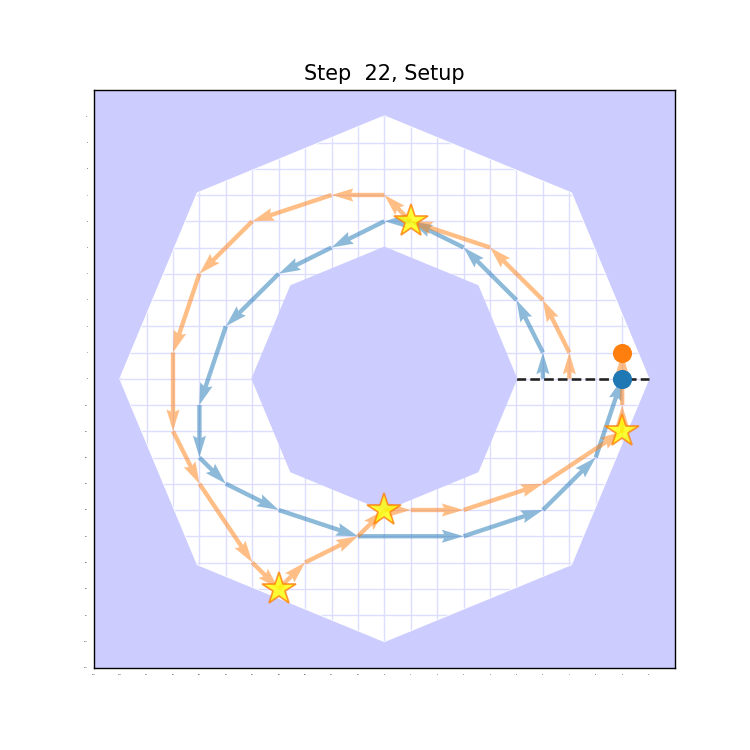

In [24]:
def testWidgets():
    tc    = TrackCreator()
    outer = tc.regularPolygon(8,10)
    inner = tc.regularPolygon(8,5)
    track = Track(inner,outer)
    game  = Game(track)
    ui    = WidgetInterface()
    ui.startup(game)

testWidgets()

In [19]:
def testCrazy():
    ui   = WidgetInterface()
    ui.startup(filename="crazy.json")
    
# testCrazy()

## The `PlotInterface` specialisation

In [20]:
class PlotInterface(Interface):
    
    def __init__(self,**drawer_kw):
        super(PlotInterface,self).__init__(**drawer_kw)
        self._draw.setPicker(self._handlePick)
        
    def _message(self,txt,car=None):
        self._draw.message(txt, car.color() if car is not None else None)
        
    def _next(self):
        nomore = super()._next()
        
        if nomore: 
            self._message("End of game!")
            self._draw.drawProjection(None)
            self._drawRefresh()
            return 
        
        car = self._game.current()
        self._draw.drawProjection(car)
            
    def _handlePick(self,dx,dy,x,y):
        car = self._game.current()
        if car is None:
            self._next()
            return
            
        
        self._message("Accelerate by ({},{})".format(dx,dy),car)
        if not self._move(car, dx, dy):
            # self._message("Invalid move ({},{})".format(dx,dy),car)
            return 
        
        self._drawRefresh()
        timer = self._draw.fig().canvas.new_timer(interval=100)
        timer.add_callback(self._next)
        timer.single_shot = True
        timer.start()
        # self._next()
        
    def startup(self,game=None,filename=None):
        super().startup(game,filename)
        
        print(self._game)
        if self._game is not None:
            self._next()

Shooting ray from [0. 0.] to [11.  0.]
Intersection with outer [[10.  0.]]


<IPython.core.display.Javascript object>


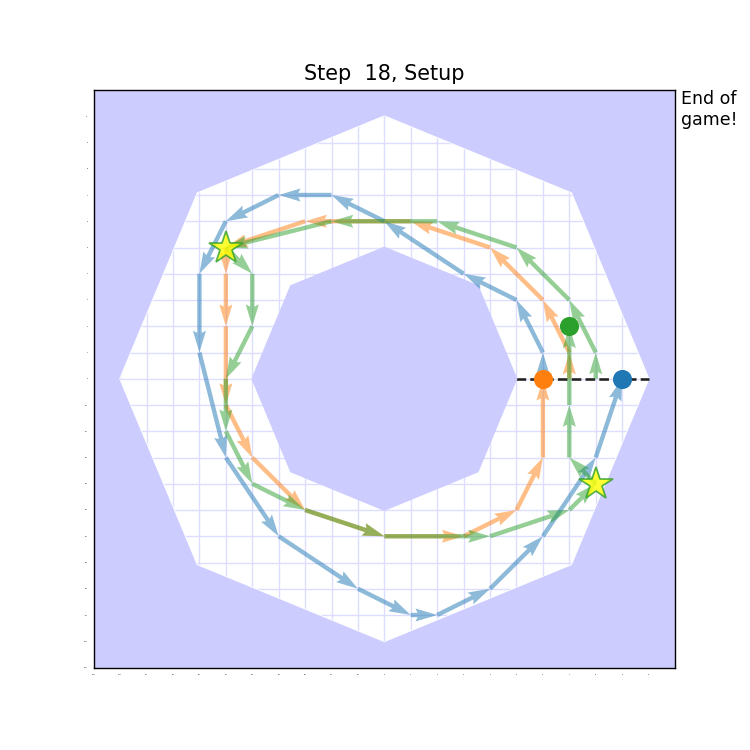

In [25]:
def testPlot():
    tc    = TrackCreator()
    outer = tc.regularPolygon(8,10)
    inner = tc.regularPolygon(8,5)
    track = Track(inner,outer)
    game  = Game(track)
    game.addCars()
    ui    = PlotInterface()
    ui.startup(game)
    
    return ui
    
ui = testPlot()

Shooting ray from [-0.65302611  1.        ] to [17.26860106  1.        ]
Intersection with outer [[15.9453269  1.       ]]


<IPython.core.display.Javascript object>


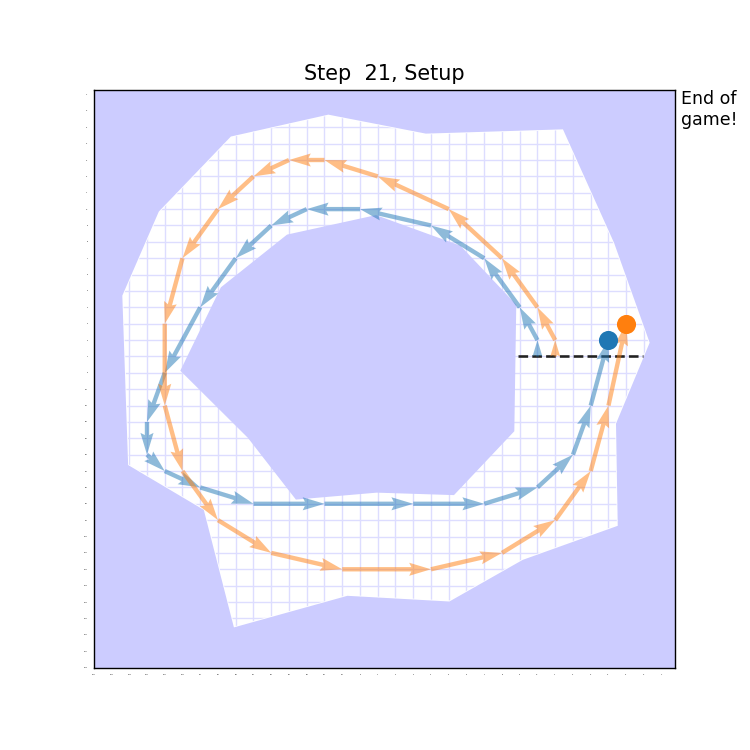

In [26]:
def testPlotRandom():
    tc    = TrackCreator()
    inner = tc.randomPolygon(12,9)
    outer = tc.randomPolygon(17,15,phi=-np.pi)
    track = Track(inner,outer)
    game  = Game(track,collisions=True)
    game.addCars(2)
    ui    = PlotInterface(prj_kw={'alpha':.5,'markersize':7})
    ui.startup(game)
    
    return ui
    
ui = testPlotRandom()